# **Algoritmo de Grover**

**CENÁRIO 1**: *2 qubits e 1 alvo*. Verificar se o estado alvo aparece com alta probabilidade nas medições

- Espaço de busca: $N = 2^2 = 4$
- Estado alvo (o que eu quero procurar): $|11\rangle$
- Número ideal de iterações: $k \approx \left\lfloor \frac{\pi}{4}\sqrt{N} \right\rfloor = \left\lfloor \frac{\pi}{4} \cdot 2 \right\rfloor = 1$

In [36]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

In [31]:
# função que mostrar o estado matmaticamente
def mostra_estado_latex(qc):
    """
    Função para mostrar o estado em latex
    
    :param qc: circuito quântico
    """
    state = Statevector.from_instruction(qc)
    display(state.draw('latex'))

def medir_e_inverter_bits(qc):
    """
    Função com o obejtivo de medir e inverter a ordem os bits clássicos para facilitar a leitura

    :param qc: circuito quântico
    """
    # Mapeamento manual na medição para simular Big-Endian
    for i in range(qc.num_qubits):
        qc.measure(i, qc.num_qubits - 1 - i)

def oraculo(qc: QuantumCircuit, alvo: str):
    """
    Implementa o oráculo de Grover para um único estado alvo.
    
    :param qc: circuito quântico
    :param alvo: string binária para o alvo, ex: "00", "01", "10", "11"
    
    Observação:
    - Assume que len(alvo) == número de qubits do circuito
    - Usa a convenção lógica q0 = alvo[0]
    """

    n = len(alvo)

    # 1. Aplicar X nos qubits cujo alvo é '0'
    for i, bit in enumerate(alvo):
        if bit == '0':
            qc.x(i)

    # 2. Aplicar Z controlado (caso geral)
    if n == 1:
        qc.z(0)
    elif n == 2:
        qc.cz(0, 1)
    else:
        # multi-controlled Z usando H + MCX + H
        qc.h(n - 1)
        qc.mcx(list(range(n - 1)), n - 1)
        qc.h(n - 1)

    # 3. Desfazer os X
    for i, bit in enumerate(alvo):
        if bit == '0':
            qc.x(i)

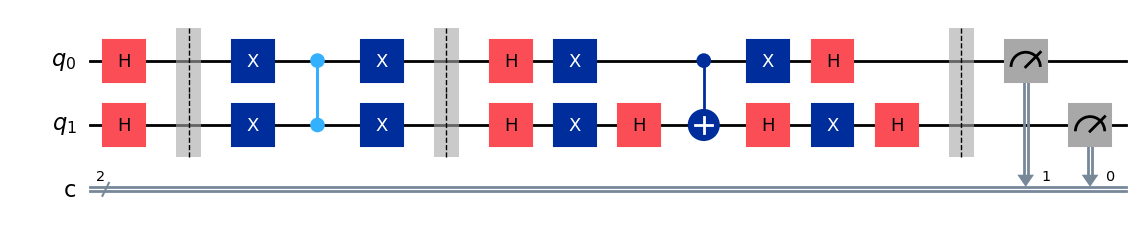

In [32]:
# Circuito com 2 qubits e 2 bits clássicos
qc = QuantumCircuit(2, 2)

# Passo 1: Colocar todos os estados em superposição uniforme
qc.h([0, 1])
# mostra_estado_latex(qc)
qc.barrier()

# Passo 2 (Oráculo): Aplicar portas lógicas quânticas de acordo com o alvo
#
# Por exemplo: achar o estado |11>, basta aplicar CZ
# qc.cz(0, 1)
#
# Para a achar o estado |01>, deve-se aplicar X, CZ e X
# qc.x(0)
# qc.cz(0, 1)
# qc.x(0)
# MACETE >>> A ideia é aplicar X no bit que é 0, aplicar CZ e depois aplicar novamente o X no mesmo lugar
#
# Abaixo, estou chamando um função que criei para aplicar as portas do oráculo de acordo com o alvo
oraculo(qc,"00")

qc.barrier()

# Difusor de Grover
qc.h([0, 1])
qc.x([0, 1])

qc.h(1)
qc.cx(0, 1)
qc.h(1)

qc.x([0, 1])
qc.h([0, 1])
qc.barrier()

# Mede os quibits 0 e 1 nos bits clássicos 0 e 1
# qc.measure([0, 1], [0, 1])

medir_e_inverter_bits(qc)

qc.draw('mpl')

In [37]:
# Simulador moderno
simulator = AerSimulator()

# Transpilação (obrigatória no 2.0)
qc_transpiled = transpile(qc, simulator)

# Execução
job = simulator.run(qc_transpiled, shots=1024)
result = job.result()

# Resultados
counts = result.get_counts()

In [34]:
counts

{'00': 1024}

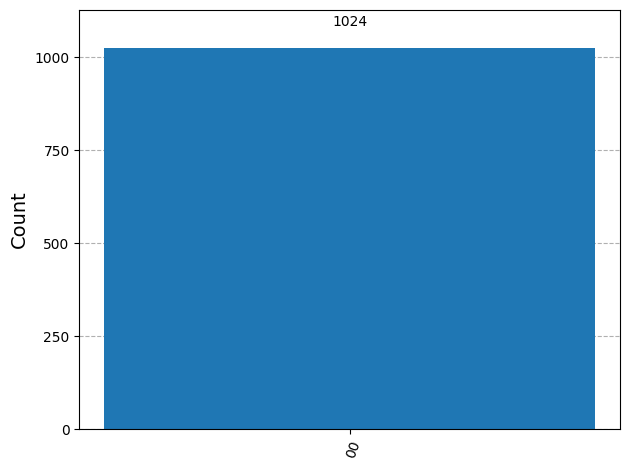

In [35]:
plot_histogram(counts)